In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc3 as pm


from ipywidgets import interact
import ipywidgets as ipyw

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
az.style.use('arviz-darkgrid')

In [4]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [5]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

##### <center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Intro to Probabilistic programming</h1>
<h2 align="center">Automating inference, not modeling</h2> 
    


<br>
<br>
<br>
<br>
<br>

## Aims

* Learn to build simple models with PyMC3 and ArviZ
* Learn about posterior predictive distribution

# Probabilistic programming


* Although conceptually simple, fully probabilistic models often lead to analytically intractable expressions

* The _promise of probabilistic programming_  is clear separation of modeling and inference. Practitioners should focus on modeling, not _computational/mathematical details_

* Models are written in code and then _compiled_ to get the posterior

* _Universal inference engines_ can solve any probabilistic model (over-statement!)

## PyMC3: Probabilistic programming with Python
<br>

<center><img src="img/PyMC3_banner.svg" width=300></center>

* Model building
    * A large collections of probability distributions
    * A clear and powerful syntax
    * Integration with the PyData-stack


* Inference
    * Markov Chain Monte Carlo (NUTS, MH)
    * Sequential Monte Carlo (SMC, SMC-ABC)
    * Variational Inference


* Computational backend:
    * Theano --> Speed, automatic differenciation, mathematical optimizations, GPU Support
    * PyMC4 --> [Tensorflow Probability](https://medium.com/@pymc_devs/theano-tensorflow-and-the-future-of-pymc-6c9987bb19d5)

In [6]:
np.random.seed(123)
n_experimentos = 4
theta_real = .35  # In real examples this value is unknown
datos = stats.bernoulli.rvs(theta_real, size=n_experimentos)
datos

array([1, 0, 0, 0])

In [7]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1, beta=1)  # a priori
    y = pm.Bernoulli('y', p=θ, observed=datos)  # likelihood
    trace = pm.sample(1000)  # Universal Inferece engine!

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


## ArviZ: Exploratory analysis of Bayesian models

<br>
<br>
<center><img src="img/logo_arviz.png" width=400></center>
<br>


* Diagnoses of the quality of the inference
* Model criticism, including evaluations of both model assumptions and model predictions
* Comparison of models, including model selection or model averaging
* Preparation of the results for a particular audience

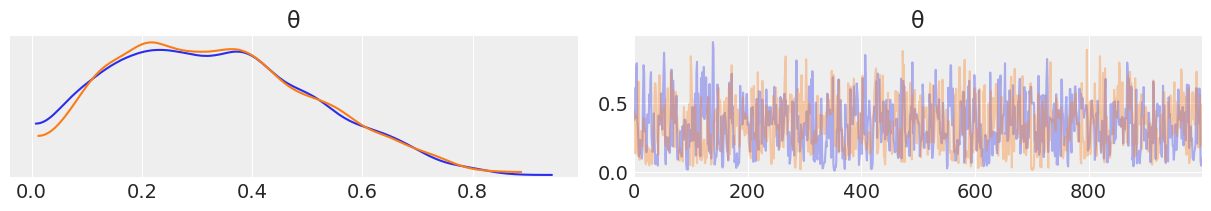

In [8]:
az.plot_trace(trace);

In [9]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.337,0.18,0.043,0.672,0.006,0.004,828.0,828.0,771.0,804.0,1.0


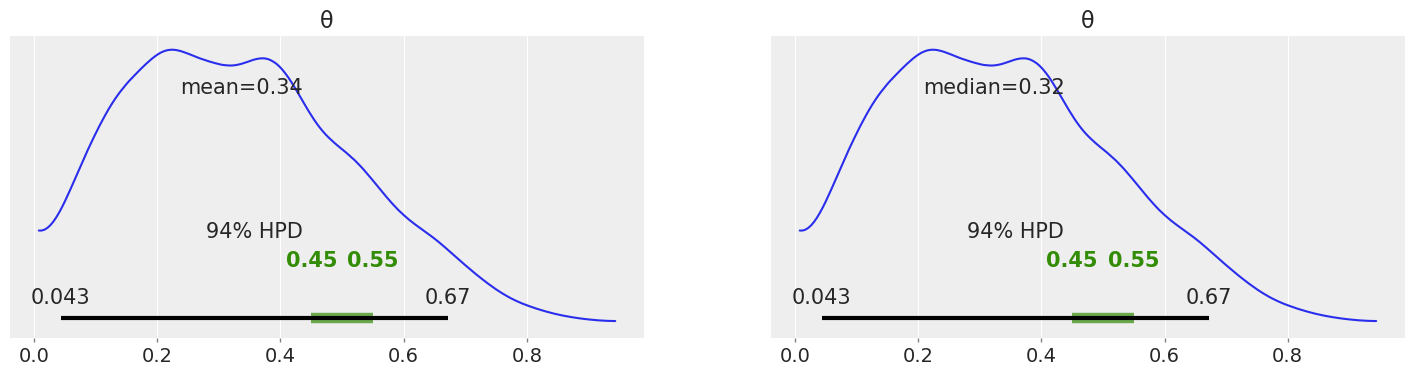

In [10]:
_, ax = plt.subplots(1, 2, figsize=(18, 4))
az.plot_posterior(trace, rope=[0.45, 0.55], ax=ax[0]);
az.plot_posterior(trace, point_estimate='median', rope=[0.45, 0.55], ax=ax[1])

# Estimación puntuales a partir del posterior Bayesianas

<br>

La **estimación puntual** Bayesiana consistirá en un número que resuma adecuadamente la distribución a posteriori. Pero ¿Cuál? ¿Su media, su moda, su mediana, algún cuantil?

* Definimos una función de *pérdida* asociada a la acción *estimación* $\hat{\theta}$ cuando  el valor del parámetro es $\theta$, como  $C(\theta, \hat{\theta})$.

* Diferentes *funciones de pérdida* conducirán a diferentes estimadores.
* La estimación bayes será aquella que minimice la pérdida (a posteriori) esperada.

## Funciones de perdida

<br>

Algunas funciones de pérdida comunes

|  |Función de Pérdida  | Estimador|
|--|--------------------|----------|
|Cuadrática |$$C(\theta, \hat{\theta})=\alpha\left(\hat{\theta}-\theta\right)^2$$| Media |
|Lineal-simétrica|$$C(\theta, \hat{\theta})=\alpha |\hat{\theta}-\theta|$$| Mediana |
| Cero-uno |$$C(\theta, \hat{\theta})=\alpha\,\mathcal{I}_{(\beta, \infty)}\left(|\hat{\theta}-\theta|\right)$$| Moda| 


<br>
Teoría de decisión Bayesiana --> Usar la estimación a posteriori de $\theta$ para computar el valor $\hat \theta$ que minimiza el valor esperado de la función de pérdida

(0.33734232971009986, 0.3228316937229122)

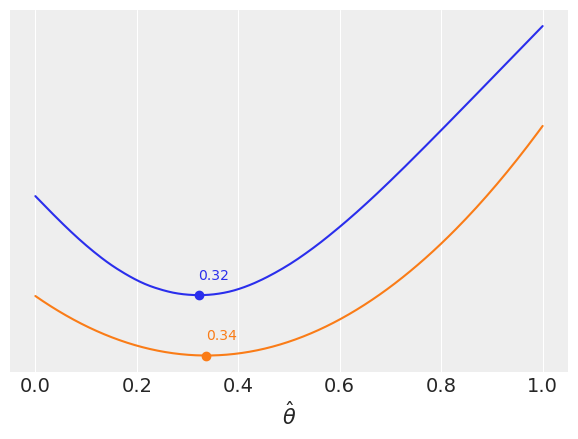

In [11]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')
    
np.mean(θ_pos), np.median(θ_pos)

## Funciones de pérdida

<br>

* Differentes funciones de perdida están asociadas a diferentes estimadores puntuales

* Las funciones de perdida deberían estar motivadas por el problema que se intenta solucionar

* Al tener muestras del posterior es posible utilizar funciones de perdida sin preocuparnos por la tractabilidad matemática 

# weird loss function
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$');

## Estimador Máximo a Posteriori (MAP)


Un estimador puntual tradicionalmente usado es el MAP:

    
$$\hat{\theta}= \arg\max_{\theta\in\Theta} p(\theta \mid \textbf{y})=\arg\max_{\theta \in \Theta} p(\textbf{y} \mid \theta)p(\theta)$$

Que corresponde a la moda a posteriori de $ p(\theta \mid \textbf{x})$.

El estimador MAP es una generalización del clásico estimador de máxima verosimilitud/likelihood (EMV). Si suponemos la distribución a priori no informativa $p(\theta)\propto 1$, el estimador MAP coincide con el EMV $\hat{\theta}= \arg\max_{\theta\in\Theta} p(\textbf{y} \mid \theta)$.

## El problema de los tanques alemanes

<br>

* During Second World War II the allies collected serial numbers from captured tanks


* How to estimate the number of total German tanks from this information? 

In [12]:
serial_numbers = np.array([15, 20, 28])
with pm.Model() as model:
    N = pm.DiscreteUniform('N', lower=serial_numbers.max(), upper=serial_numbers.max()*10)
    #N = pm.Deterministic('N', pm.Exponential('N_', 1/10) + serial_numbers.max())
    #N = pm.Exponential('N', 1/10) + serial_numbers.max()
    y_obs = pm.DiscreteUniform('y_obs', lower=0, upper=N, observed=serial_numbers)

    trace = pm.sample(2000)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [N]


The estimated number of effective samples is smaller than 200 for some parameters.


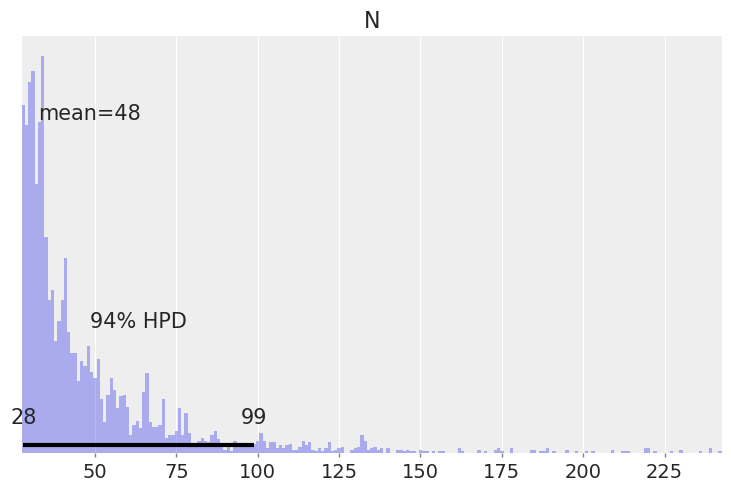

In [13]:
az.plot_posterior(trace, var_names='N');

## Modelos Multiparamétricos

<br>

Prácticamente todos los modelos de interés en estadística tienen más de un parámetro (multiparamétricos).

* Los parámetros que no son de inmediato interés pero son necesarios para definir un modelo de forma completa se llaman \textit{nuisance parameters} (o parámetro estorbo). (Ej. La varianza cuando queremos estimar la media de una distribución Gaussiana).


* Al incorporar estos parámetros permitimos que la incertidumbre que tenemos sobre ellos se propague de forma adecuada a los resultados.

## Gaussian-model or inferring the speed of light

At the end of the 19th century Simon Newcomb conducted several experiments to determine the speed of light. In one of them, Newcomb measured the time it took for the light to travel 7,442 meters.

In [14]:
datos = np.array([24.828, 24.826, 24.833, 24.824, 24.834, 24.756, 24.827, 24.816,
                  24.84 , 24.798, 24.829, 24.822, 24.824, 24.821, 24.825, 24.83 ,
                  24.823, 24.829, 24.831, 24.819, 24.824, 24.82 , 24.836, 24.832,
                  24.836, 24.828, 24.825, 24.821, 24.828, 24.829, 24.837, 24.825,
                  24.828, 24.826, 24.83 , 24.832, 24.836, 24.826, 24.83 , 24.822,
                  24.836, 24.823, 24.827, 24.827, 24.828, 24.827, 24.831, 24.827,
                  24.826, 24.833, 24.826, 24.832, 24.832, 24.824, 24.839, 24.828,
                  24.824, 24.825, 24.832, 24.825, 24.829, 24.827, 24.828, 24.829,
                  24.816, 24.823])

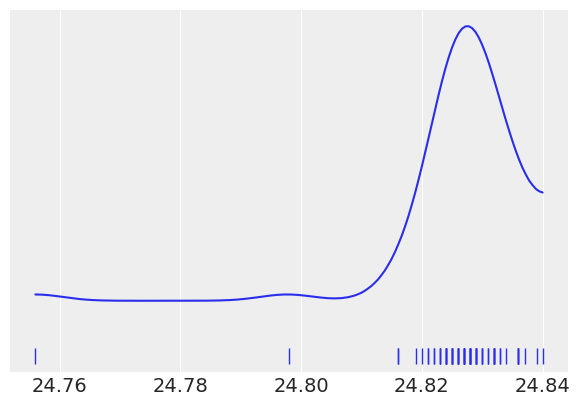

In [15]:
az.plot_kde(datos, rug=True)
plt.yticks([]);




\begin{align} 
\mu &\sim U(l, h) \\
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) \\
y &\sim \mathcal{N}(\mu, \sigma)
\end{align}

In [16]:
with pm.Model() as modelo_g:
    # Priors
    μ = pm.Uniform('μ', 24, 25)
    #μ = pm.Normal('μ', 24, 10) # alternative prior
    σ = pm.HalfNormal('σ', sd=1)
    #σ = pm.HalfNormal('σ', sd=datos.std() * 100)
    # Likelihood
    y = pm.Normal('y', mu=μ, sd=σ, observed=datos)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]


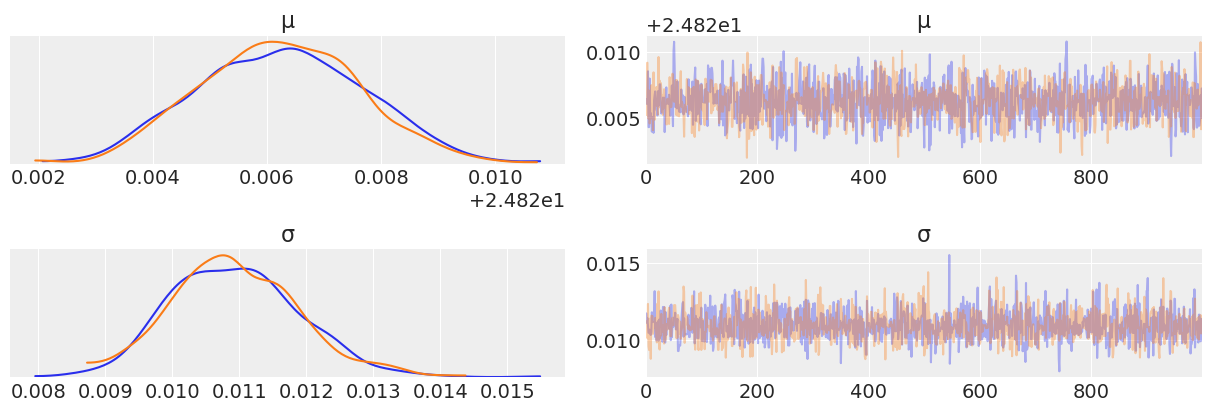

In [17]:
az.plot_trace(trace_g);

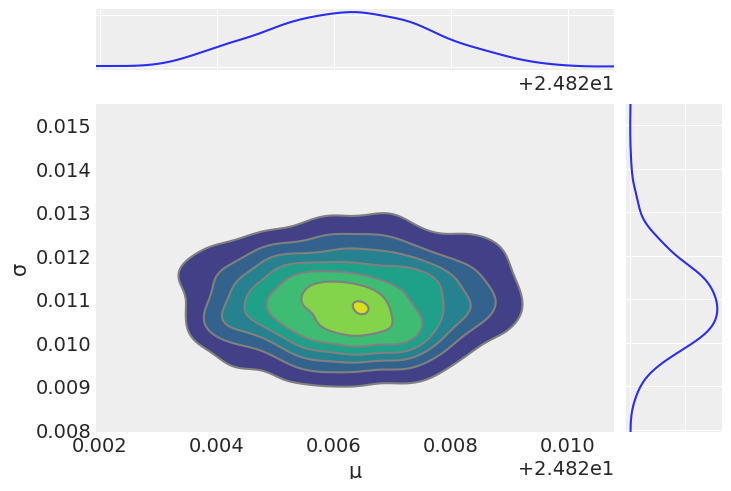

In [18]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

## The posterior as the only estimator

* The posterior representas everything we known about a problem, given a model and a dataset.

* As a general rule once we got the posterior we compute some expectation 


$$
J = \int \varphi(\theta) \ \ p(\theta \mid y) d\theta
$$

* For example, to compute the mean of $\theta$ we replace $\varphi(\theta)$ with $\theta$:

$$
\bar \theta = \int \theta \ \ p(\theta \mid y) d\theta
$$

* Notice this is a weighted average, each value of $\theta$ is _weighted_ by the _posterior_.

* In practice (as we sample from the posterior) this integrals are just sums

## Posterior predictive distribution

**Conceptually**: The distribution of _predicted data_ ($\tilde{y}$) according to the _posterior_ (i.e the logical consequence of model and observed data)


**Mathematically**
\begin{equation}
p(\tilde{y} \,|\, y) = \int p(\tilde{y} \,|\, \theta) \, p(\theta \,|\, y) \, d\theta
\end{equation}


* $y$ --> observed data
* $\theta$  --> model's parameters


**computationally**

Following the speed of light example:

1. Pick an $i$ element from PyMC3's `trace` $\theta_i = (\mu_i, \sigma_i)$
2. Generate a random value from the distribution used as _likelihood_ with parameters $\theta_i$ --> $\tilde{y_i}  \sim N(\mu_i, \sigma_i)$
3. Repeat 1 and 2 $N$ times

In [19]:
pp_samples = pm.sample_posterior_predictive(trace_g, 100, modelo_g)

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/sampling.py:1254: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


## Posterior predictive distributions

* Simulated data can be used to make predictions
* Simulated data can be used to check models predictions (criticize the model)

arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


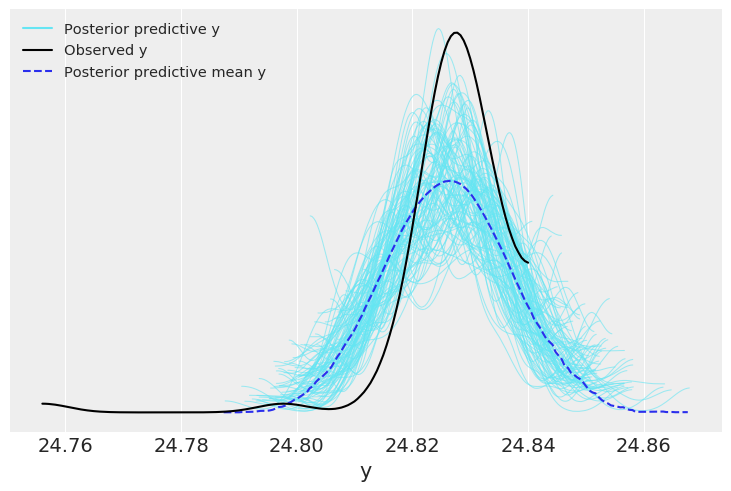

In [20]:
pp_data = az.from_pymc3(trace=trace_g, posterior_predictive=pp_samples)
az.plot_ppc(pp_data, alpha=0.6);

<center>
<img src="img/bayesian_workflow_watanabe.png" width=700>
</center>

[Mathematical Theory of Bayesian Statistics](https://www.crcpress.com/Mathematical-Foundations-of-Bayesian-Statistics/Watanabe/p/book/9781482238068)

### Coal mining disasters

<br>

* We have a record of the number of accidents in coal mines, located in the United Kingdom, that occurred between 1851 and 1962 ([Jarrett, 1979](http://biomet.oxfordjournals.org/content/66/1/191.abstract)).


* We want to study the effect of safety regulations in the decrease in the number of accidents. We are interested in finding out the year in which the rate changed also in estimating both rates.



* Some data is missing
    * Missing data $\tilde{y}$ can be automatically estimated using the posterior predictive distribution $\int p(\tilde{y} \,|\, \theta) \, p(\theta \,|\, y) \, d\theta$:

<br>
<br>

From [PyMC3 docs](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters)

In [21]:
accidents = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                                  3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                                  2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                                  1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                                  0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                                  3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                                  0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
years = np.arange(1851, 1962)

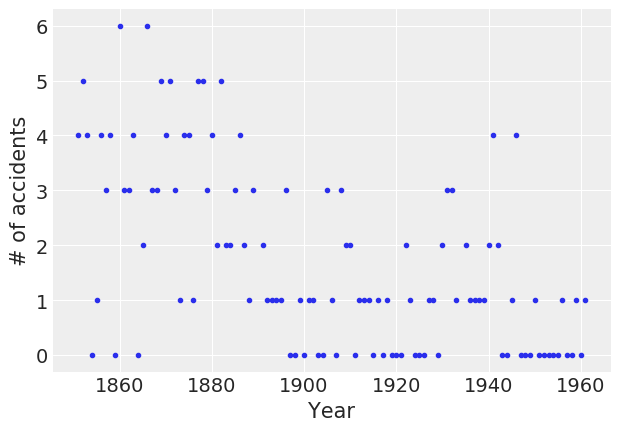

In [22]:
plt.plot(years, accidents, '.')
plt.ylabel("# of accidents")
plt.xlabel("Year");

<img src="img/modelo_disasters.png" width=350>

\begin{equation}
y \sim Poisson(rate)
\end{equation}

\begin{equation}
rate = \begin{cases}
t_0, \text{if } t \ge cp,\\
t_1, \text{if } t \lt cp
\end{cases}
\end{equation}

\begin{align}
t_0 \sim Exp(\lambda) \\
t_1 \sim Exp(\lambda) \\
cp \sim U(L, H)
\end{align}


In [23]:
with pm.Model() as model_cat:

    cp = pm.DiscreteUniform('cp', lower=years.min(), upper=years.max())
    t_0 = pm.Exponential('t_0', 1/10)
    t_1 = pm.Exponential('t_1', 1/10)
    
    rate = pm.math.switch(cp >= years, t_0, t_1)

    acc = pm.Poisson('acc', rate, observed=accidents)
    trace_cat = pm.sample(5000)

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/model.py:1345: ImputationWarning: Data in acc contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [acc_missing]
>>Metropolis: [cp]
>NUTS: [t_1, t_0]


The number of effective samples is smaller than 10% for some parameters.


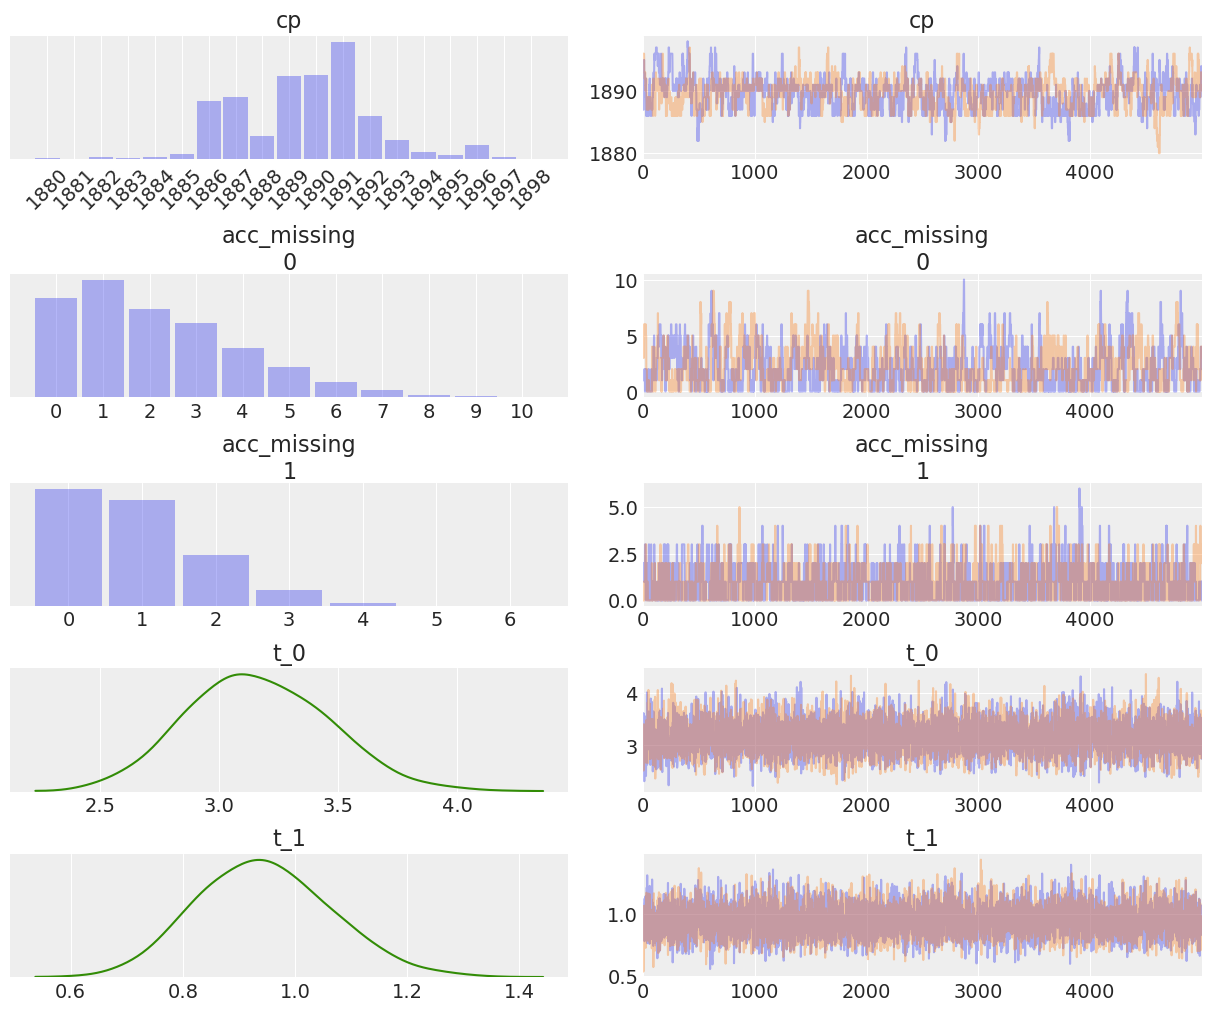

In [24]:
ax = az.plot_trace(trace_cat, combined=True);
[ticks.set_rotation(45) for ticks in ax[0, 0].get_xticklabels()];

In [25]:
az.summary(trace_cat)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
cp,1889.617,2.481,1886.000,1894.000,0.165,0.117,227.0,227.0,228.0,507.0,1.01
acc_missing[0],2.124,1.811,0.000,5.000,0.101,0.071,323.0,323.0,351.0,889.0,1.01
acc_missing[1],0.926,0.956,0.000,3.000,0.028,0.020,1192.0,1114.0,1227.0,1608.0,1.00
t_0,3.164,0.301,2.612,3.724,0.004,0.003,4710.0,4710.0,4678.0,5471.0,1.00
t_1,0.946,0.120,0.734,1.178,0.002,0.001,4008.0,3967.0,4058.0,5202.0,1.00


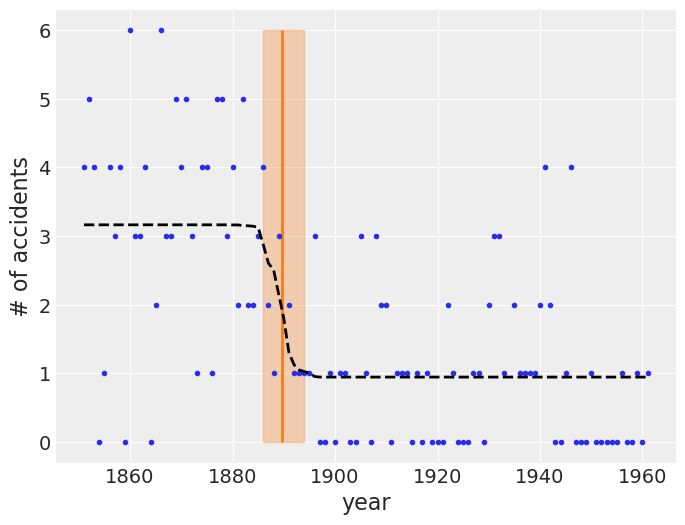

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(years, accidents, '.')
plt.ylabel("# of accidents", fontsize=16)
plt.xlabel("year", fontsize=16)

plt.vlines(trace_cat['cp'].mean(), accidents.min(), accidents.max(), color='C1', lw=2)
accidents_ave = np.zeros_like(accidents, dtype='float')
for i, year in enumerate(years):
    idx = year < trace_cat['cp']
    accidents_ave[i] = ((trace_cat['t_0'][idx].sum() + trace_cat['t_1'][~idx].sum()) 
                              / (len(trace_cat) * trace_cat.nchains))

pc_hpd = az.hpd(trace_cat['cp'])
plt.fill_betweenx([accidents.min(), accidents.max()], pc_hpd[0], pc_hpd[1], alpha=0.3, color='C1');
plt.plot(years, accidents_ave,  'k--', lw=2);

## Clasificador Bayesiano óptimo (CBO)

* Dado espacio de hipótesis $H$ y las observaciones $\textbf{y}$ ¿Cuál es la hipótesis $h \in H$ más probable?
* La hipótesis máximo a posteriori $h_{MAP}$ es  
\begin{eqnarray*}
h_{MAP}
&=&\arg\max_{h\in H} p(h \mid \textbf{y})\\
&=&\arg\max_{h\in H} \frac{p(\textbf{y} \mid h)P(h)}{p(\textbf{y})}\\
&=& \arg\max_{h\in H} p(\textbf{y} \mid h)P(h)
\end{eqnarray*}

En _Machine learning_ es común hablar de clases en vez de hipótesis.

## Propiedades CBO

<br>

* Maximiza la probabilidad de que una nueva instancia se clasifique correctamente.


* El espacio de hipótesis del clasificador es una combinación lineal de las predicciones de las hipótesis $H$ a las que se aplica el teorema de Bayes.


* Aplicar el clasificador Bayesiano optimo puede ser muy costoso (muchas hipótesis). 

## Clasificador Bayes ingenuo


* Es un CBO con algunas hipótesis simplificadoras.
* Simplificación 1: asumir la independencia de la distribución condicional $$p(\textbf{y}| h) = \prod_i p(y_i | h),$$
en otras palabras independencia entre las variables predictoras, por eso recibe el apelativo de *ingenuo*.

* Simplificación 2: la probabilidad de los datos ( o atributos) es constante,  podemos eliminar el denominador.  
* El Clasificador Naive Bayes será entonces:
$$\arg\max_{h\in H} p(h)\prod_i p(y_i | h).$$

## Naive Bayes classifiers


We want to classify vectors of discrete-valued features, $x \in \{1, \cdots , K\}^D$, where $K$ is the number of values for each feature, and $D$ is the number of features.

We can do by specifying the class conditional distribution, $p(x \mid y = c)$.

Assuming features are **conditionally independent** given the class label we can write:

$$p(\boldsymbol{x} \mid y=c, \boldsymbol{\theta}) = \prod_{j=1}^D p(x_j \mid y=c, \boldsymbol{\theta}_{jc} )$$

Dependiendo el tipo de datos podemos tener distintas versiones del clasificador bayesiano ingenuo.

* En el caso de variables reales podríamos usar:

$p(\boldsymbol{y} \mid h, \boldsymbol{\theta}) = \prod_{j=1}^D \mathcal{N}(y_j \mid \mu_{jc}, \sigma_{jc})$

* En el caso de variable binarias/binomiales, $x_j \in \{0, 1\}$, podríamos usar::

$p(\boldsymbol{y} \mid h, \boldsymbol{\theta}) = \prod_{j=1}^D \operatorname{Ber}(y_j \mid \mu_{jc})$, donde $\mu_{jh}$ es la probabilidad que la variable $j$ suceda en la hipótesis $h$.

* En el caso de variables categóricas, $x_j \in \{1, \cdots , K\}$, podríamos usar::

$p(\boldsymbol{y} \mid h, \boldsymbol{\theta}) = \prod_{j=1}^D \operatorname{Cat}(y_j \mid \mu_{jc})$, donde $\mu_{jh}$ es un histograma sobre los $K$ posibles valores para $y_j$ en la hipótesis $h$.

In [27]:
## fake data, 3 Gaussian distributions
a = np.random.normal(0, [1, 0.5], (100, 2))
b = np.random.normal(0, [2, 2], (50, 2))
c = np.random.normal(2, [1, 0.5], (70, 2))
data = np.concatenate([a, b, c])
y_cat = [0] * len(a) + [1] * len(b) + [2] * len(c)
n_cat = len(np.unique(y_cat))
N_data = len(data)

In [28]:
with pm.Model() as nb_model:
    # Priors
    # Number of categories
    pi = pm.Dirichlet('pi', a=np.ones(n_cat)*0.5)
    # mean prior distribution per category
    mu = pm.Normal('mu', mu=0, sd=100, shape=(n_cat, 2))  # shape=(cat, n_features)
    # standard deviation prior per category
    sigma = pm.HalfNormal('sigma', 100, shape=(n_cat, 2)) # shape=(cat, n_features)

    # Assign classes to data points
    # Notices true classes are observed
    z = pm.Categorical('z', pi, shape=N_data, observed=y_cat)

    # likelihood
    # Classes are independent and normally distributed
    y = pm.Normal('y', mu=mu[z], sd=sigma[z], observed=data)
    nb_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu, pi]


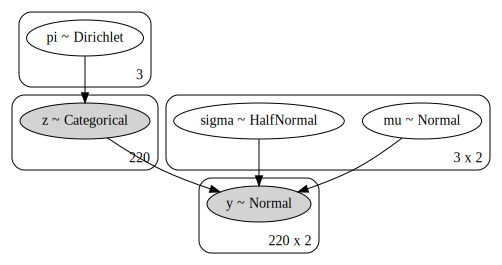

In [29]:
pm.model_to_graphviz(nb_model)

In [30]:
az.summary(nb_trace)[['mean']].T

,"mu[0,0]","mu[0,1]","mu[1,0]","mu[1,1]","mu[2,0]","mu[2,1]",pi[0],pi[1],pi[2],"sigma[0,0]","sigma[0,1]","sigma[1,0]","sigma[1,1]","sigma[2,0]","sigma[2,1]"
mean,0.265,0.023,0.194,0.842,2.235,1.884,0.455,0.228,0.317,1.063,0.474,1.849,2.029,0.996,0.43


In [31]:
K = 3 # number of topics
V = 4 # size of vocabulary

# 13 documents with 5 words each
data = np.array([[0, 0, 0, 0, 0], 
                 [0, 0, 0, 0, 1], 
                 [0, 0, 0, 1, 1], 
                 [0, 0, 0, 0, 1], 
                 [0, 0, 0, 0, 1], 
                 [0, 0, 0, 0, 1], 
                 [0, 0, 0, 0, 0], 
                 [1, 1, 1, 2, 2], 
                 [1, 1, 1, 1, 2], 
                 [1, 1, 1, 2, 1], 
                 [1, 1, 1, 2, 2], 
                 [2, 2, 2, 3, 3], 
                 [2, 2, 2, 3, 3]])
# number of documents
D = data.shape[0]

# flatten and index data
data_flatten = np.reshape(data, data.shape[0]*data.shape[1])
data_index = np.repeat(np.arange(data.shape[0]), data.shape[1])

In [32]:
with pm.Model() as nb_model_2:
    # Global topic distribution
    θ = pm.Dirichlet("θ", a=np.ones(K)* 0.5)
    
    # Word distributions for K topics
    ϕ = pm.Dirichlet("ϕ", a=np.ones(V) * 0.5,  shape=(K, V))
    
    # Topic of documents
    z = pm.Categorical("z", p=θ, shape=D)
    
    # Words in documents
    w = pm.Categorical("w",
                       p=ϕ[z][data_index],
                       observed=data_flatten)

    nb_trace_2 = pm.sample(2000, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [ϕ, θ]
>CategoricalGibbsMetropolis: [z]


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7104285220249786, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


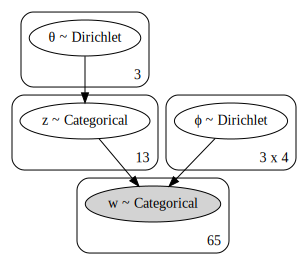

In [33]:
pm.model_to_graphviz(nb_model_2)

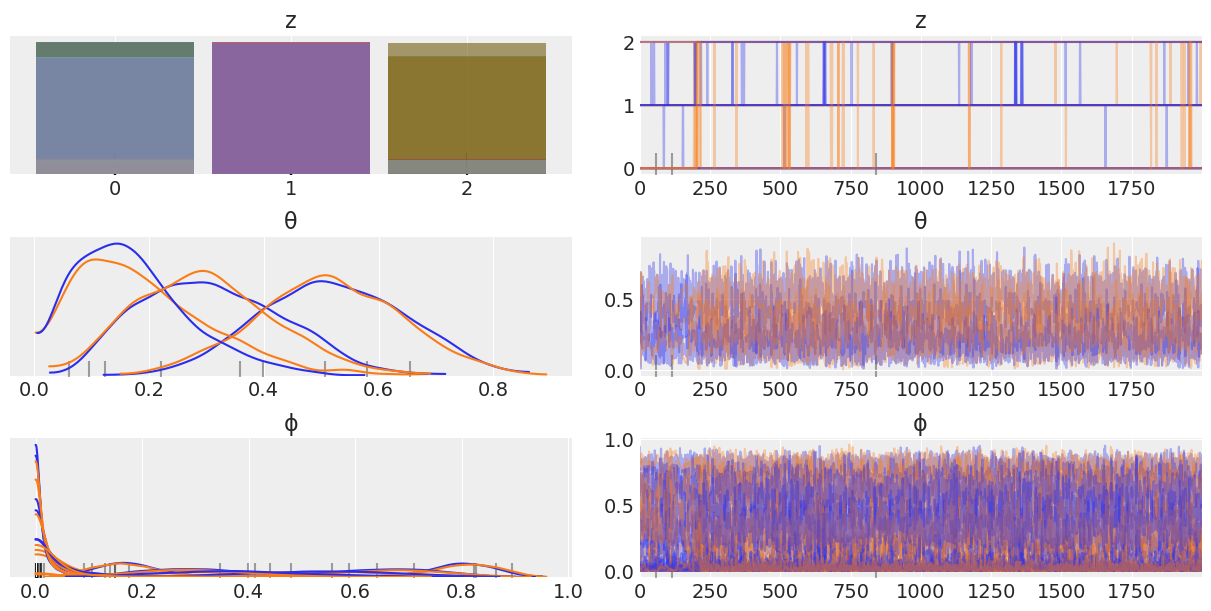

In [34]:
az.plot_trace(nb_trace_2, compact=True);

## Exercises


1. Use PyMC3 to reproduce the beta-binomial example from the previous notebook (use the 3 priors).


2. Replace the beta distribution with a uniform one in the interval [0,1]. How similar are the results compared with the prior $beta(\alpha=1, \beta=1)$? What about using a larger interval such as [-1, 2]?

3. In the following definition of a probabilistic model, identify the prior and the the likelihood and the posterior:

$$y_i \sim Normal(\mu, \sigma)$$
$$\mu \sim Normal(0, 10)$$
$$\sigma \sim HalfNormal(25)$$

4. In the previous model, how many dimensions will the posterior have? Compare it with the model for the coin-flipping problem.

3. Modify `model_g`, change the prior for the mean to a Gaussian distribution centered at the empirical mean, and try a couple of reasonable values for the standard deviation of this prior. How robust/sensitive are the inferences to these changes? What do you think about using a Gaussian, which is an unbounded distribution (goes from $-\infty$ to $\infty$), to model bounded data such as this?

4. Refit the _speed of light data_, but this time change the likelihood of `model_g` to a Student's t-distribution. This distribution has 3 parameters "mu", "sigma" and "nu", try using and exponential distribution with mean 30 as a prior for "nu". Compare the estimated values for mu and sigma using `model_g` and this model with the Student's t-distribution. What do you observe?

5. Discuss with your classmates the results of the tips example

6. What does the PyMC3 function `pm.model_to_graphviz` do?